In [37]:
import einops
import numpy as np
import random
import torch
import os
from IPython.display import display
from PIL import Image
from pytorch_lightning import seed_everything
from FBSDiff.tools import create_model, load_state_dict
from FBSDiff.fbs_sampler import FBS_Sampler

In [26]:
# resolution of the generated image
img_size=(512, 512)
# set the total steps of the inversion trajectory, we apply 1000 steps for best inversion quality
inversion_steps = 1000
# set the total steps of the sampling trajectory and the reconstruction trajectory
sampling_steps = 100
# set the value of lambda (0~1), the larger the value, the shorter the calibration phase.
lambda_end = 0.5
# the end step of the calibration phase
end_step = encode_steps * lambda_end
ddim_eta = 0

In [3]:
# load the model
model = create_model('./models/model_ldm_v15.yaml').cuda()
model.load_state_dict(load_state_dict('./models/v1-5-pruned-emaonly.ckpt', location='cuda'), strict=False)
sampler = FBS_Sampler(model)

LDMWrapper: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

/home/kemove/anaconda3/envs/controlnet/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loaded model config from [./models/model_ldm_v15.yaml]
Loaded state_dict from [./models/v1-5-pruned-emaonly.ckpt]


In [5]:
# function for loading a reference image
def load_img(img_path):
    img = np.array(Image.open(img_path).resize(img_size))
    img = (img.astype(np.float32) / 127.5) - 1.0  # -1 ~ 1
    img_tensor = torch.from_numpy(img).permute(2, 0, 1)[None, ...].repeat(num_samples, 1, 1, 1).cuda()  # n, 3, 512, 512
    return img_tensor

In [6]:
# define function for DDIM inversion
def inversion(model, num_samples, img_tensor, img_size, inversion_steps):
    H, W = img_size
    un_cond = {"c_crossattn": [model.get_learned_conditioning([''] * num_samples)]}
    shape = (4, H // 8, W // 8)
    if os.path.exists('latent.pt'):
        os.remove('latent.pt')
    encoder_posterior = model.encode_first_stage(img_tensor)
    z = model.get_first_stage_encoding(encoder_posterior).detach()
    sampler.make_schedule(ddim_num_steps=inversion_steps)
    latent, out = sampler.encode(x0=z, cond=un_cond, t_enc=inversion_steps)
    torch.save(latent, 'latent.pt')

In [38]:
# define function for sampling with low_FBS
def low_FBS_sampling(sampler, img_size, low_pass_thres, ref_latent, text_prompt, sampling_steps, end_step, 
                     seed=-1, num_samples=1, unconditional_guidance_scale=7.5):
    with torch.no_grad():
        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)
        H, W = img_size
        un_cond = {"c_crossattn": [model.get_learned_conditioning([''] * num_samples)]}
        cond = {"c_crossattn": [model.get_learned_conditioning([text_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)
        sampler.make_schedule(ddim_num_steps=sampling_steps)
        x_rec = sampler.decode_with_low_FBS(ref_latent=ref_latent, cond=cond, t_dec=sampling_steps,
                                            unconditional_guidance_scale=unconditional_guidance_scale,
                                            unconditional_conditioning=un_cond, threshold=low_pass_thres,
                                            end_step=end_step)
        x_samples = torch.clip(model.decode_first_stage(x_rec), min=-1, max=1)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().astype(
            np.uint8)

    for sample in x_samples:
        display(Image.fromarray(sample))

In [39]:
# define function for sampling with high_FBS
def high_FBS_sampling(sampler, img_size, high_pass_thres, ref_latent, text_prompt, sampling_steps, end_step, 
                     seed=-1, num_samples=1, unconditional_guidance_scale=7.5):
    with torch.no_grad():
        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)
        H, W = img_size
        un_cond = {"c_crossattn": [model.get_learned_conditioning([''] * num_samples)]}
        cond = {"c_crossattn": [model.get_learned_conditioning([text_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)
        sampler.make_schedule(ddim_num_steps=sampling_steps)
        x_rec = sampler.decode_with_high_FBS(ref_latent=ref_latent, cond=cond, t_dec=sampling_steps,
                                            unconditional_guidance_scale=unconditional_guidance_scale,
                                            unconditional_conditioning=un_cond, threshold=high_pass_thres,
                                            end_step=end_step)
        x_samples = torch.clip(model.decode_first_stage(x_rec), min=-1, max=1)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().astype(
            np.uint8)

    for sample in x_samples:
        display(Image.fromarray(sample))

In [40]:
# define function for sampling with mid_FBS
def mid_FBS_sampling(sampler, img_size, mid_pass_thres, ref_latent, text_prompt, sampling_steps, end_step, 
                     seed=-1, num_samples=1, unconditional_guidance_scale=7.5):
    with torch.no_grad():
        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)
        H, W = img_size
        un_cond = {"c_crossattn": [model.get_learned_conditioning([''] * num_samples)]}
        cond = {"c_crossattn": [model.get_learned_conditioning([text_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)
        sampler.make_schedule(ddim_num_steps=sampling_steps)
        x_rec = sampler.decode_with_mid_FBS(ref_latent=ref_latent, cond=cond, t_dec=sampling_steps,
                                            unconditional_guidance_scale=unconditional_guidance_scale,
                                            unconditional_conditioning=un_cond, threshold=mid_pass_thres,
                                            end_step=end_step)
        x_samples = torch.clip(model.decode_first_stage(x_rec), min=-1, max=1)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().astype(
            np.uint8)

    for sample in x_samples:
        display(Image.fromarray(sample))

In [28]:
# load a reference image
img_path = 'Edinburgh.jpg'
img_tensor = load_img(img_path)
# inversion trajectory
inversion(model, num_samples, img_tensor, img_size, inversion_steps)

Selected timesteps for ddim sampler: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 2

Encoding Image: 100%|███████████████████████| 1000/1000 [01:18<00:00, 12.69it/s]


In [35]:
# load the inverted latent noise
latent = torch.load('latent.pt').cuda()

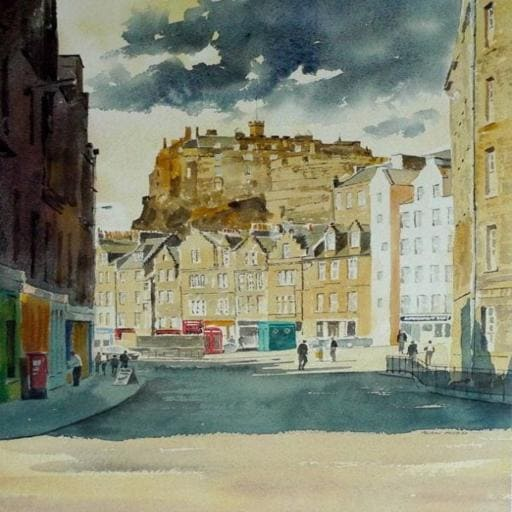

In [58]:
# display reference image
display(Image.open('Edinburgh.jpg'))

Global seed set to 39689


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.17it/s]


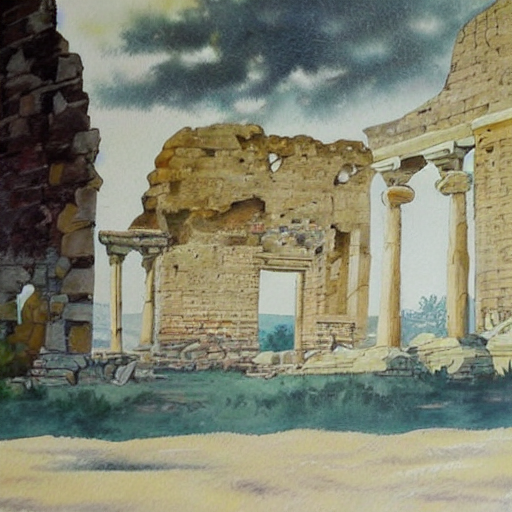

In [43]:
# test low_FBS
th_lp = 90  # set the low-pass filtering threshold th_lp
text_prompt = 'painting of ancient ruins'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 44090


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


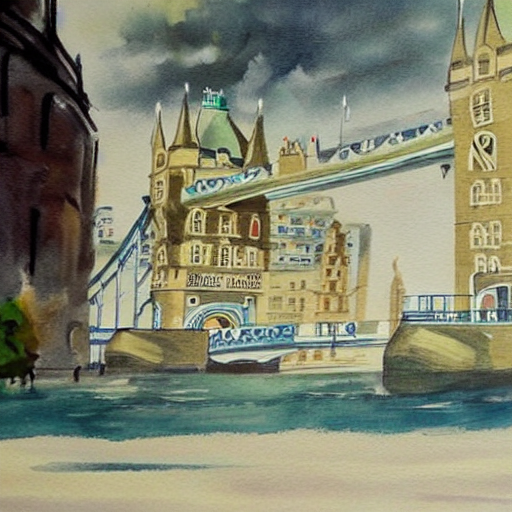

In [51]:
# try another text prompt
text_prompt = 'painting of London Tower Bridge'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 42059


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.13it/s]


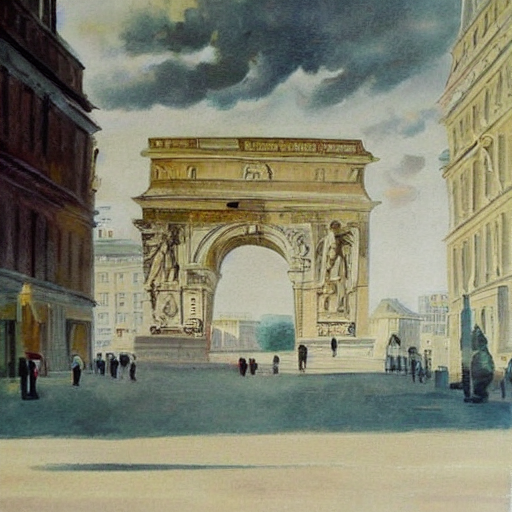

In [48]:
# try another text prompt
text_prompt = 'painting of the Triumphal Arch'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 4571


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.10it/s]


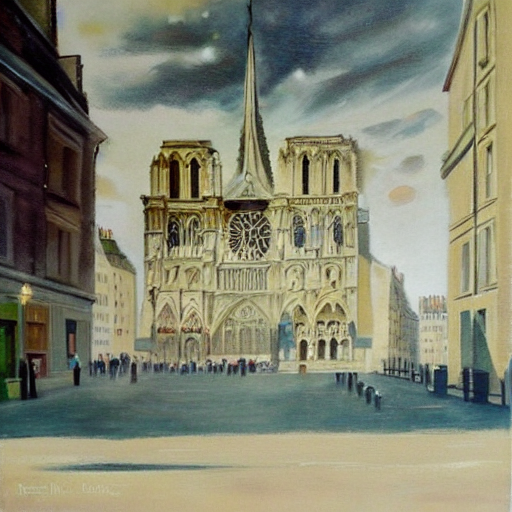

In [53]:
# try another text prompt
text_prompt = 'painting of the Notre Dame de Paris'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 20984


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


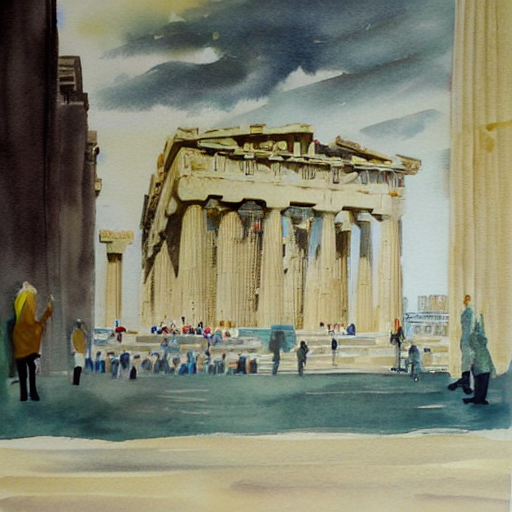

In [56]:
# try another text prompt
text_prompt = 'painting of the Parthe Dame de Paris'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

In [61]:
# test low_FBS with another reference image
# load a new reference image
img_path = 'painting.jpg'
img_tensor = load_img(img_path)
# re-run the inversion trajectory to obtain the new latent noise
inversion(model, num_samples, img_tensor, img_size, inversion_steps)

Selected timesteps for ddim sampler: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 2

Encoding Image: 100%|███████████████████████| 1000/1000 [01:18<00:00, 12.66it/s]


In [63]:
# re-load the inverted latent noise
latent = torch.load('latent.pt').cuda()

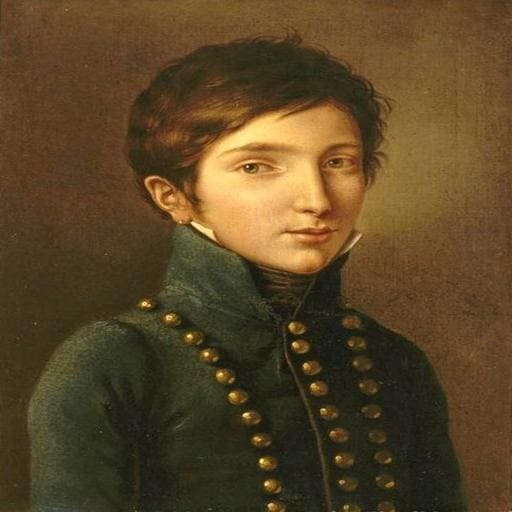

In [62]:
# display reference image
display(Image.open('painting.jpg'))

Global seed set to 371


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.03it/s]


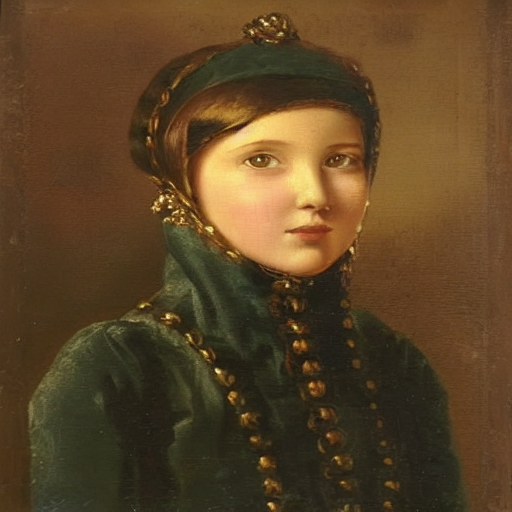

In [73]:
# test low_FBS
th_lp = 80
text_prompt = 'painting of a young lady'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 15562


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.07it/s]


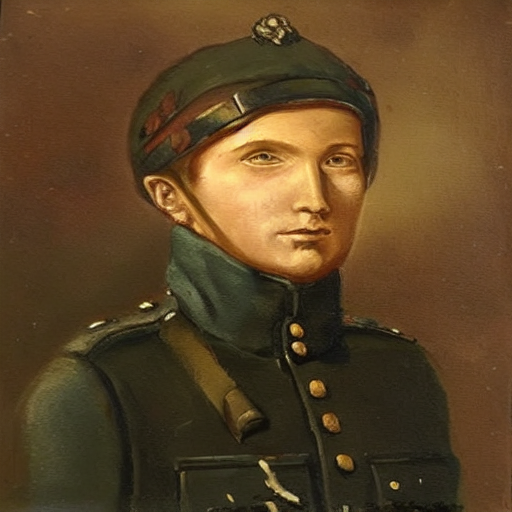

In [76]:
# test another text prompt
th_lp = 90
text_prompt = 'painting of a soldier'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 17689


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  5.97it/s]


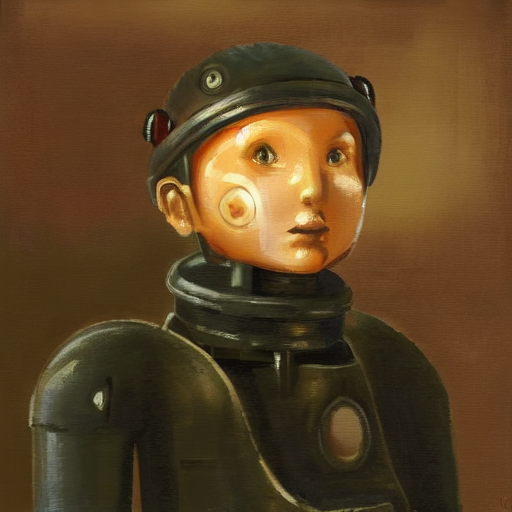

In [81]:
# test another text prompt
th_lp = 80
text_prompt = 'painting of a robot'
low_FBS_sampling(sampler, img_size, th_lp, latent, text_prompt, sampling_steps, end_step)

In [82]:
# test high_FBS
# load a new reference image
img_path = 'photo.jpg'
img_tensor = load_img(img_path)
# re-run the inversion trajectory to obtain the new latent noise
inversion(model, num_samples, img_tensor, img_size, inversion_steps)

Selected timesteps for ddim sampler: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 2

Encoding Image: 100%|███████████████████████| 1000/1000 [01:19<00:00, 12.56it/s]


In [83]:
# re-load the inverted latent noise
latent = torch.load('latent.pt').cuda()

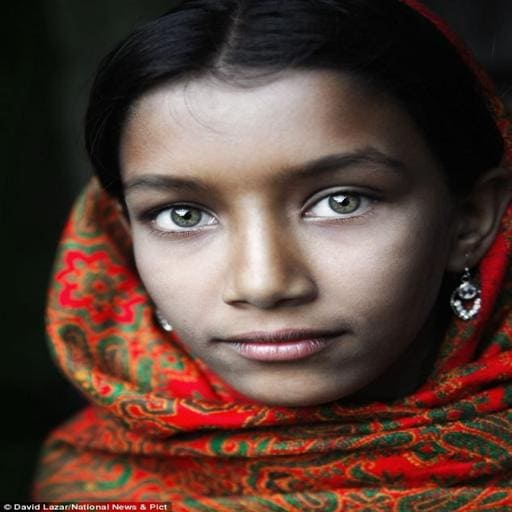

In [84]:
# display reference image
display(Image.open('photo.jpg'))

Global seed set to 31304


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.17it/s]


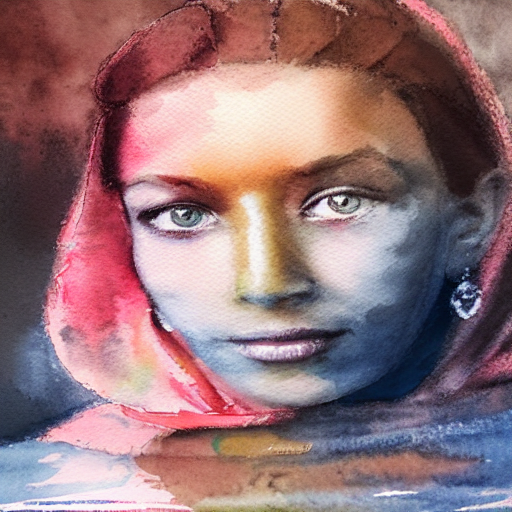

In [86]:
# test high_FBS
th_hp = 3  # set the high-pass filtering threshold th_hp
text_prompt = 'water color of a woman'
high_FBS_sampling(sampler, img_size, th_hp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 23012


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


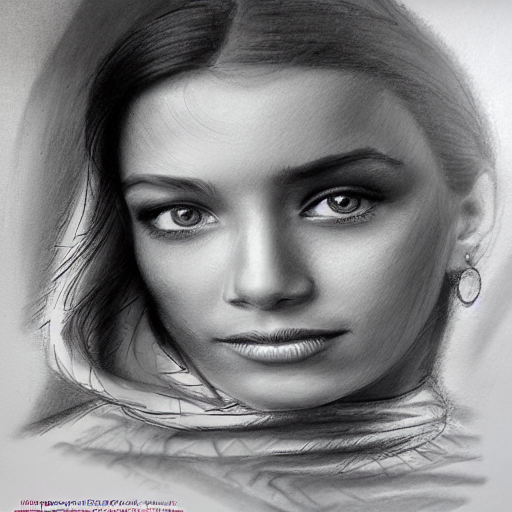

In [93]:
# try another text prompt
th_hp = 7  # set the high-pass filtering threshold th_hp
text_prompt = 'pencil sketch painting of a lady'
high_FBS_sampling(sampler, img_size, th_hp, latent, text_prompt, sampling_steps, end_step)

Global seed set to 50423


Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
        0.3470, 0.3323, 0.3178, 0.3037, 0.2899, 0.2763, 0.2631, 0.2503, 0.2378,
        0.2257, 0.2139, 0.2026, 0.191

Decoding image: 100%|█████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


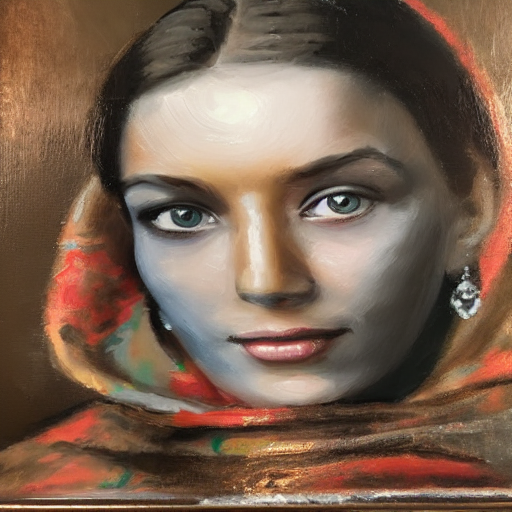

In [95]:
# try another text prompt
th_hp = 5  # set the high-pass filtering threshold th_hp
text_prompt = 'oil painting of a lady'
high_FBS_sampling(sampler, img_size, th_hp, latent, text_prompt, sampling_steps, end_step)